# Proyecto de Clasificación de Alzheimer con Redes Neuronales
## Metodología CRISP-DM: Fase 1, 2 y 3

Este notebook cubre las dos primeras etapas del proyecto: Comprensión del Negocio y Comprensión de los Datos, que incluye un Análisis Exploratorio de Datos (AED) completo y preprocesamiento.

## Fase 1: Comprensión del Negocio (Business Understanding)
En esta primera fase, definimos los objetivos del proyecto y los criterios de éxito. Aunque es un proyecto académico, lo tratamos como un problema real.

### 1.1. Objetivo Principal
El objetivo central es desarrollar y evaluar modelos de Deep Learning capaces de clasificar imágenes de resonancia magnética (MRI) cerebral en cuatro categorías distintas de la enfermedad de Alzheimer:
* No Dementes (Sin demencia)
* Demencia muy leve
* Demencia leve
* Demencia moderada

### 1.2. Objetivos Específicos
* Análisis de Datos: Realizar un análisis exploratorio exhaustivo del dataset para entender la distribución de las clases, la calidad y las características de las imágenes.
* Preprocesamiento: Preparar y acondicionar las imágenes para que puedan ser procesadas eficientemente por los modelos de redes neuronales.
* Modelado y Comparación:
    * Construir, entrenar y evaluar un modelo de Red Neuronal Artificial (RNA) tradicional.
    * Construir, entrenar y evaluar un modelo de Red Neuronal Convolucional (CNN), especializada en el reconocimiento de imágenes.
* Evaluación: Medir el rendimiento de ambos modelos utilizando métricas clave como Accuracy, Precision, Recall, F1-Score y la Curva ROC. Analizar críticamente los resultados, prestando especial atención al impacto del desbalanceo de clases.

### 1.3. Criterios de Éxito
* Criterio Mínimo: Lograr un modelo que supere la clasificación aleatoria y demuestre capacidad de aprendizaje, con un Accuracy superior al 50%.
* Criterio Deseado: Desarrollar un modelo CNN que alcance un Accuracy superior al 80% en el conjunto de prueba, demostrando un rendimiento robusto.
* Criterio Principal: Entregar dos notebooks funcionales, bien documentados y organizados, que sigan la metodología CRISP-DM y presenten una comparación clara y justificada del rendimiento entre el modelo RNA y el CNN.

## Fase 2: Comprensión de los Datos (Data Understanding)
Ahora que el objetivo está claro, nos sumergimos en los datos. Esta fase incluye la carga de los datos y el Análisis Exploratorio (AED).

### 2.1. Importación de Librerías
Primero, importamos todas las librerías que necesitaremos para el análisis.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import pickle
import io

# Configuraciones para una mejor visualización
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

### 2.2. Carga de Datos
Dado que los datos están en formato Parquet, el proceso de carga es mucho más directo. Usaremos pandas para leer los archivos. Es posible que necesites instalar la librería pyarrow para que pandas pueda leer este formato (pip install pyarrow).


In [2]:
train_file = os.path.join('train.parquet', 'train.parquet')
test_file = os.path.join('test.parquet', 'test.parquet')

# Verificamos si las rutas existen
if not os.path.exists(train_file) or not os.path.exists(test_file):
    print(f"Error: No se encontraron los archivos .parquet.")
    print(f"Asegúrate de que la estructura de carpetas y nombres de archivo sea correcta.")
else:
    print("Archivos .parquet encontrados. Cargando datos...")
    
    # Intentamos cargar los dataframes
    try:
        train_df = pd.read_parquet(train_file)
        test_df = pd.read_parquet(test_file)
        
        # Añadimos la columna 'split' para identificar el origen de los datos
        train_df['split'] = 'train'
        test_df['split'] = 'test'

        # Combinamos ambos dataframes para el análisis exploratorio
        df = pd.concat([train_df, test_df], ignore_index=True)
        
        print(f"Carga completa. Se encontraron {len(df)} imágenes en total.")
        print(f"({len(train_df)} en entrenamiento y {len(test_df)} en prueba)") 

    except Exception as e:
        print(f"Ocurrió un error al leer los archivos parquet: {e}")
        print("Asegúrate de haber instalado 'pyarrow' y reiniciado el kernel.")

Archivos .parquet encontrados. Cargando datos...
Carga completa. Se encontraron 6400 imágenes en total.
(5120 en entrenamiento y 1280 en prueba)


### 2.3. Análisis Exploratorio de Datos (AED)
En esta sección, realizaremos una investigación profunda de los datos para descubrir patrones, anomalías, y características clave que guiarán nuestras decisiones en las fases de preprocesamiento y modelado.
#### 2.3.1. Inspección Inicial de la Estructura de Datos
Primero, observemos la estructura del DataFrame combinado para entender las columnas con las que trabajaremos.

In [3]:
# Muestra las primeras 5 filas del DataFrame
print("Primeras 5 filas del DataFrame combinado:")
display(df.head())
print("\n" + "="*70 + "\n")

# Muestra información general (tipos de datos, memoria, etc.)
print("Información general del DataFrame:")
df.info()
print("\n" + "="*70 + "\n")

# Analicemos el contenido de la columna 'image' en una fila
print("Ejemplo del contenido de la columna 'image':")
# Usamos display para un formato más legible
display(df['image'].iloc[0])

Primeras 5 filas del DataFrame combinado:


,image,label,split
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,train
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,train
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,train
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,train
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,train




Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6400 non-null   object
 1   label   6400 non-null   int64 
 2   split   6400 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.1+ KB


Ejemplo del contenido de la columna 'image':


{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xc0\x00\x0b\x08\x00\x80\x00\x80\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x05\x06\x08\x04\x02\x03\x01\t\xff\xc4\x008\x10\x00\x01\x03\x03\x03\x02\x05\x03\x01\x05\x08\x03\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x11\x06\x07\x12!1\x13"AQa\x142q\x81\x08\x15R\x91\xa1#$3Bb\x92\xb1\xd1\x16r\x82\xff\xda\x00\x08\x01\x01\x00\x00?\x00\xfeUQE\x14QE\x14QE\x14QE\x14QE\x14W\xea\x1bS\x8bJ\x12\x92\xa5(\xe0$\x0c\x92\x7f\x157\x07BjK\x9a\x1c\\;\x05\xceRZ\xfb\xd4\xd4G\x14\x13\xf9\xc0\xe9\xd8\xd4l\xfbL\xdbZ\xf8\xcc\x86\xfcU{<\xd9G\xcf\xadu\xda\xb4\x95\xee\xfaH\xb6\xd9\xe7O\xc63\xf4\xd1\x96\xe63\xdb\xb0\xae\x

#### 2.3.2. Mapeo de Etiquetas y Distribución de Clases
Para que nuestro análisis sea más comprensible, mapearemos las etiquetas numéricas a sus nombres correspondientes, según lo especificado en el README.md. Este es el paso más crítico del AED, ya que nos permite cuantificar el desbalanceo de clases, un requisito explícito del proyecto.

In [4]:
# Mapeo de etiquetas numéricas a nombres de clase
label_map = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# Aplicamos el mapeo para crear una nueva columna descriptiva
df['label_name'] = df['label'].map(label_map)

print("Mapeo de etiquetas realizado. Nueva columna 'label_name' añadida.")
display(df.head())

Mapeo de etiquetas realizado. Nueva columna 'label_name' añadida.


,image,label,split,label_name
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,train,Non_Demented
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,train,Mild_Demented
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,train,Very_Mild_Demented
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,train,Very_Mild_Demented
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,train,Non_Demented


Ahora, analicemos la distribución, tanto en el conjunto total como en los subconjuntos de entrenamiento y prueba.

C:\Users\Ana_Sofia\AppData\Local\Temp\ipykernel_26472\1485268559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df, x='label_name', palette='viridis', order=df['label_name'].value_counts().index)
C:\Users\Ana_Sofia\AppData\Local\Temp\ipykernel_26472\1485268559.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=train_data, x='label_name', palette='plasma', order=train_data['label_name'].value_counts().index)
C:\Users\Ana_Sofia\AppData\Local\Temp\ipykernel_26472\1485268559.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the s

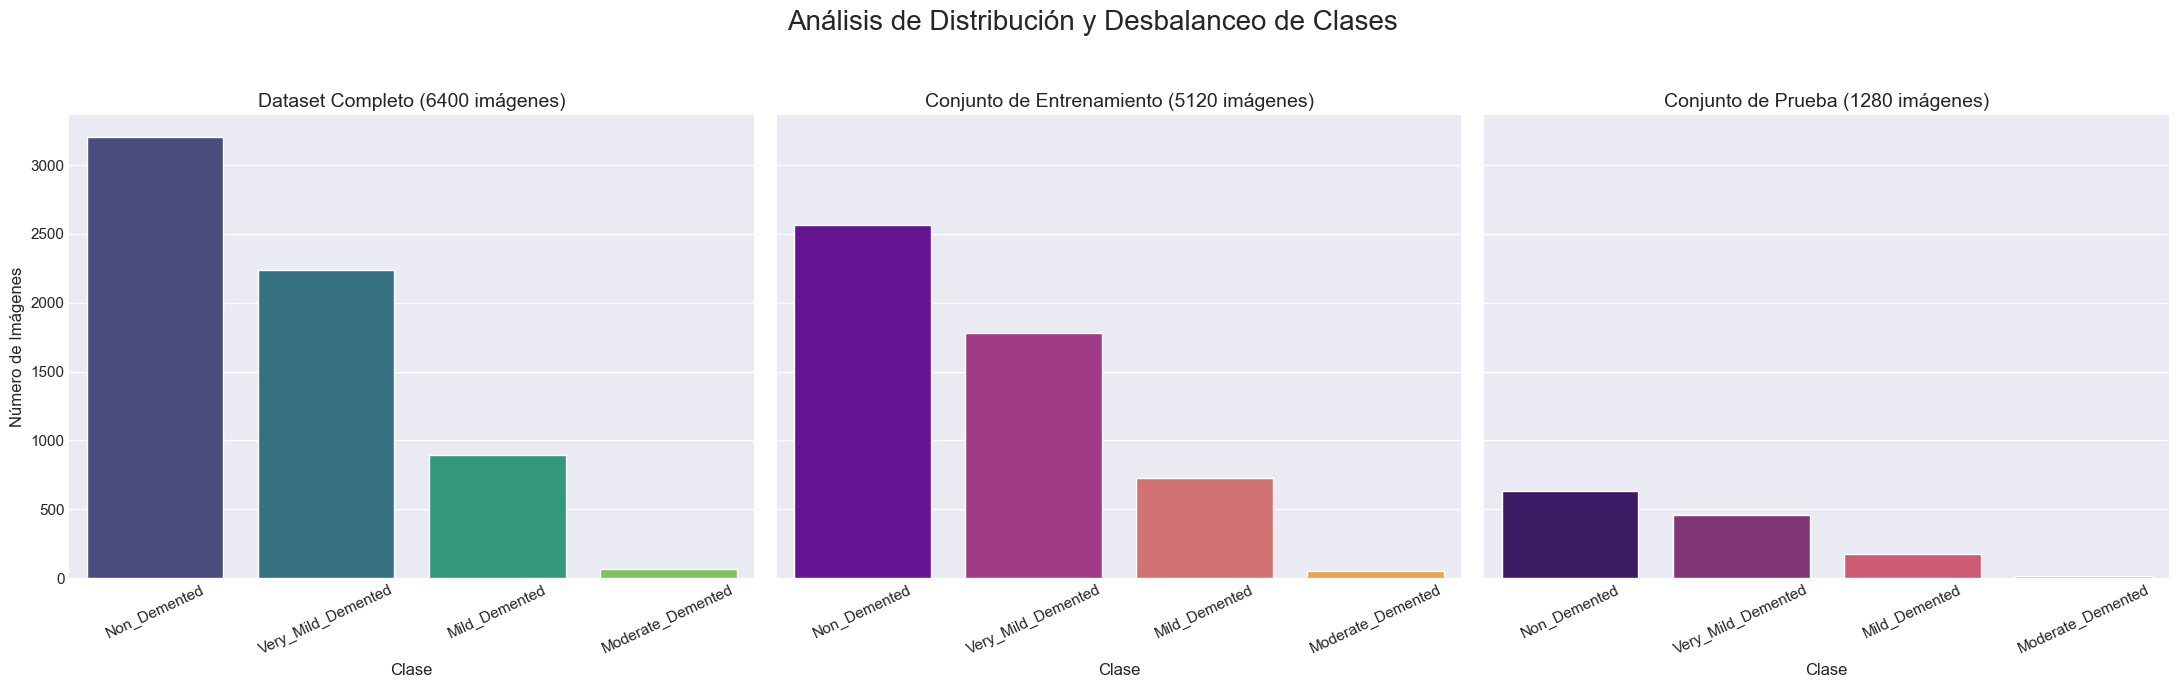

Conteo de clases en el conjunto de ENTRENAMIENTO:
label_name
Non_Demented          2566
Very_Mild_Demented    1781
Mild_Demented          724
Moderate_Demented       49
Name: count, dtype: int64


Conteo de clases en el conjunto de PRUEBA:
label_name
Non_Demented          634
Very_Mild_Demented    459
Mild_Demented         172
Moderate_Demented      15
Name: count, dtype: int64


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
fig.suptitle('Análisis de Distribución y Desbalanceo de Clases', fontsize=20)

# Gráfico 1: Dataset Completo
sns.countplot(ax=axes[0], data=df, x='label_name', palette='viridis', order=df['label_name'].value_counts().index)
axes[0].set_title('Dataset Completo (6400 imágenes)', fontsize=14)
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Número de Imágenes', fontsize=12)
axes[0].tick_params(axis='x', rotation=25)

# Gráfico 2: Conjunto de Entrenamiento
train_data = df[df['split'] == 'train']
sns.countplot(ax=axes[1], data=train_data, x='label_name', palette='plasma', order=train_data['label_name'].value_counts().index)
axes[1].set_title('Conjunto de Entrenamiento (5120 imágenes)', fontsize=14)
axes[1].set_xlabel('Clase', fontsize=12)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=25)

# Gráfico 3: Conjunto de Prueba
test_data = df[df['split'] == 'test']
sns.countplot(ax=axes[2], data=test_data, x='label_name', palette='magma', order=test_data['label_name'].value_counts().index)
axes[2].set_title('Conjunto de Prueba (1280 imágenes)', fontsize=14)
axes[2].set_xlabel('Clase', fontsize=12)
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', rotation=25)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Imprimir los conteos exactos para mayor claridad
print("Conteo de clases en el conjunto de ENTRENAMIENTO:")
print(train_data['label_name'].value_counts())
print("\n" + "="*50 + "\n")
print("Conteo de clases en el conjunto de PRUEBA:")
print(test_data['label_name'].value_counts())

Análisis del Desbalanceo de Clases:

* Desbalance Severo: Los gráficos confirman un desbalance muy pronunciado. La clase Non_Demented constituye el 50% del dataset (3200 de 6400 imágenes), mientras que la clase Moderate_Demented representa solo el 1% (64 imágenes).

* Implicaciones Críticas: Este es el hallazgo más importante del AED. Un modelo entrenado con estos datos tenderá a predecir la clase mayoritaria (Non_Demented) para maximizar su precisión (accuracy), ignorando casi por completo las clases minoritarias. Esto daría como resultado un modelo inútil en la práctica, ya que fallaría en detectar los casos más severos de la enfermedad.

* Requisito del Proyecto: El enunciado del proyecto pide explícitamente "aplicar técnicas para manejar el desbalanceo de clases". Este análisis justifica la necesidad de dichas técnicas (ej. oversampling con SMOTE, class weights en el modelo, etc.) que serán implementadas en la Fase 3: Tratamiento de los Datos.

* Distribución Estratificada: Al comparar los gráficos de entrenamiento y prueba, observamos que la proporción de clases es la misma en ambos conjuntos. Esto es excelente, ya que significa que el conjunto de prueba es una representación fiel del de entrenamiento, permitiendo una evaluación justa del modelo.

#### 2.3.3. Visualización de Imágenes de Muestra
Para comprender la naturaleza de los datos de entrada, es fundamental visualizar ejemplos de cada clase.

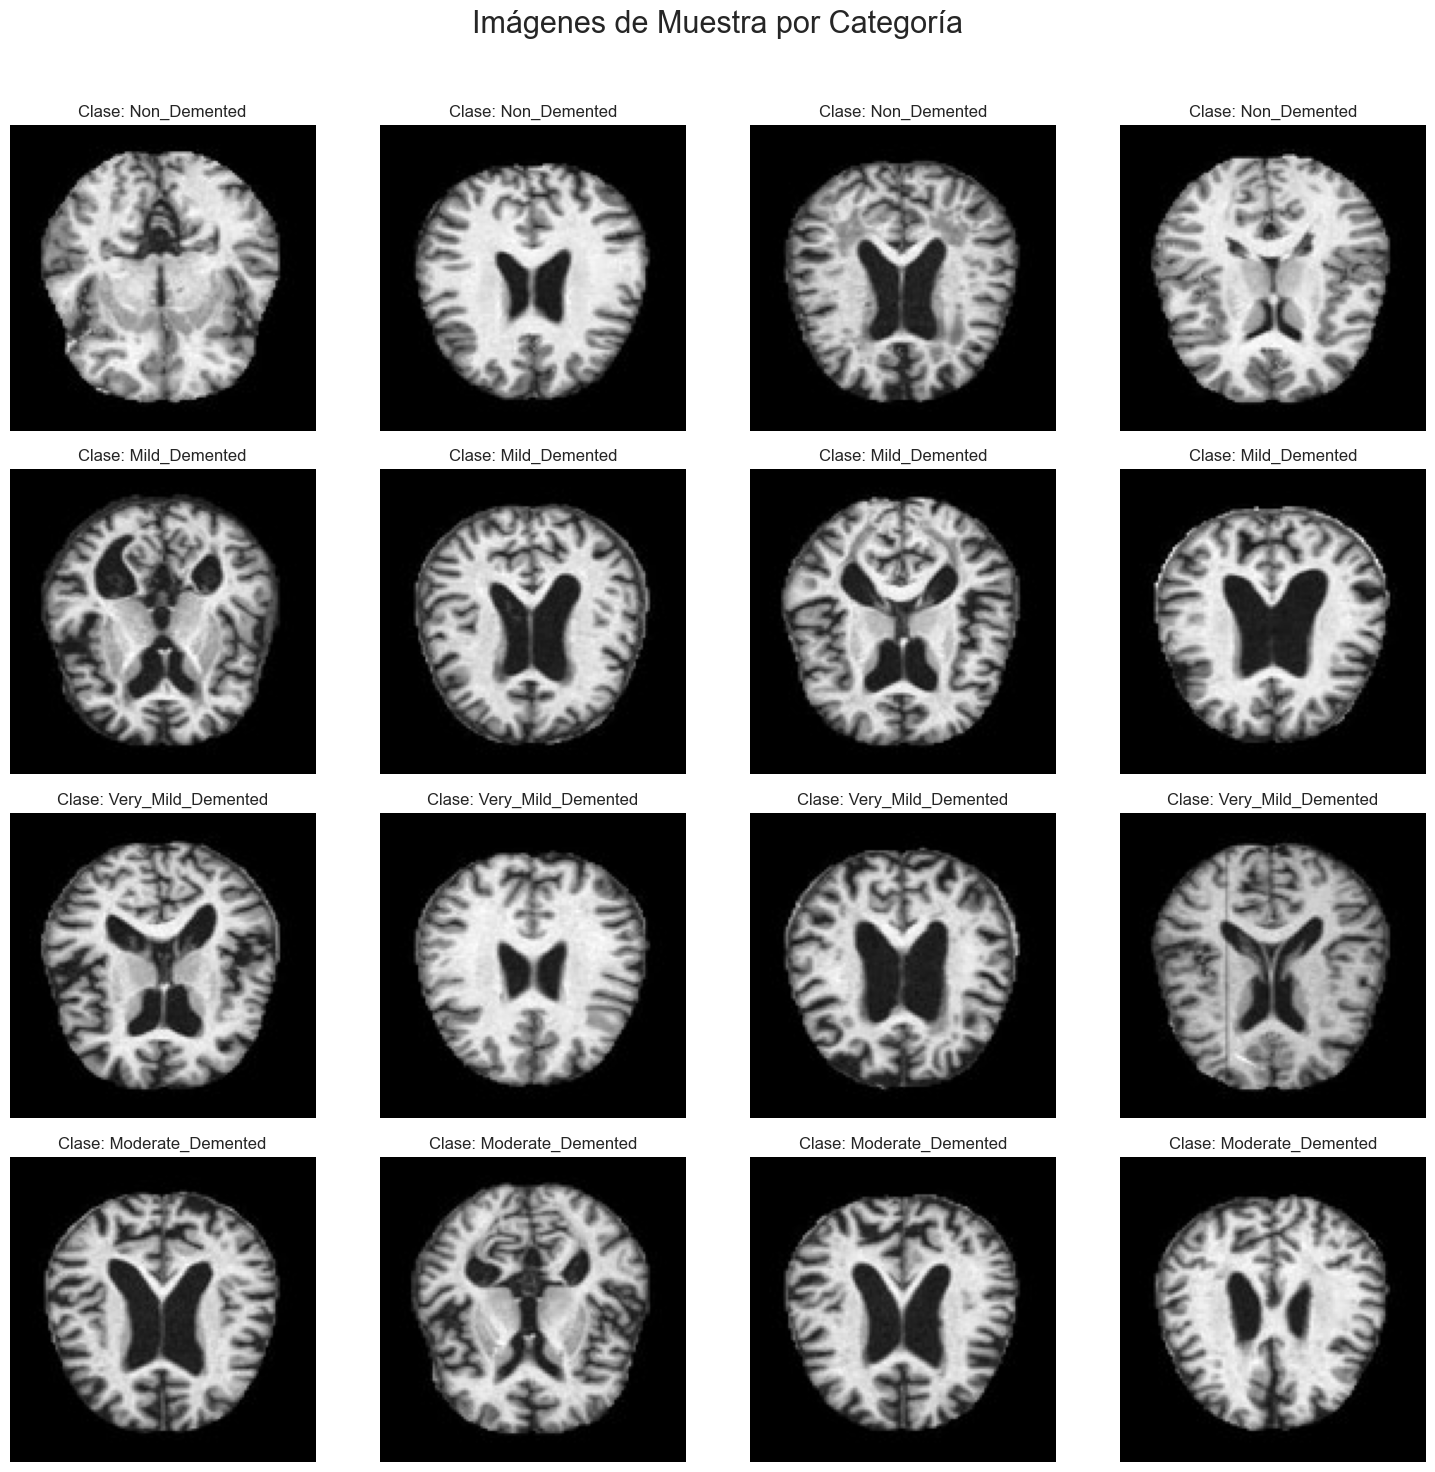

In [6]:
# Obtener las clases únicas para iterar
unique_labels = df['label_name'].unique()

# Creamos una figura para mostrar 4 imágenes por cada una de las 4 clases
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle("Imágenes de Muestra por Categoría", fontsize=22)

for i, label in enumerate(unique_labels):
    # Tomamos 4 muestras aleatorias de la clase actual
    sample_rows = df[df['label_name'] == label].sample(4)
    for j, (index, row) in enumerate(sample_rows.iterrows()):
        # Extraemos y abrimos la imagen desde los bytes
        image_bytes = row['image']['bytes']
        img = Image.open(io.BytesIO(image_bytes))
        
        # Mostramos la imagen
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(f"Clase: {label}", fontsize=12)
        axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Esta es nuestra línea base, el cerebro de un paciente sin demencia. Observen que el tejido cerebral se ve compacto y denso. Los espacios negros en el centro, que son los ventrículos (cavidades llenas de líquido), son relativamente pequeños. El cerebro llena casi por completo el cráneo.

Entonces, el trabajo de nuestra Red Neuronal Convolucional (CNN) es, en esencia, aprender a cuantificar estas características estructurales. Debe aprender a medir el tamaño relativo de los ventrículos, la densidad del tejido y la amplitud de los surcos para poder distinguir entre estas cuatro etapas. Es un problema de reconocimiento de patrones muy sutiles, especialmente entre las clases 'Non_Demented' y 'Very_Mild_Demented', lo que justifica el uso de una arquitectura de Deep Learning

#### 2.3.4. Análisis de Dimensiones y Modos de Imagen
Verificamos si todas las imágenes tienen el mismo tamaño y modo de color (ej. RGB, escala de grises). Esto es un requisito para las entradas de las redes neuronales.


In [7]:
# Usaremos contadores para registrar las dimensiones y modos
image_dims = Counter()
image_modes = Counter()

# Iteramos sobre todo el dataframe
for index, row in df.iterrows():
    try:
        image_bytes = row['image']['bytes']
        with Image.open(io.BytesIO(image_bytes)) as img:
            image_dims[img.size] += 1
            image_modes[img.mode] += 1
    except Exception as e:
        print(f"Error procesando imagen en el índice {index}: {e}")

print("Dimensiones de imagen encontradas (ancho, alto):")
for dim, count in image_dims.most_common():
    print(f"- {dim}: {count} imágenes")

print("\nModos de imagen encontrados:")
for mode, count in image_modes.most_common():
    print(f"- {mode}: {count} imágenes")

Dimensiones de imagen encontradas (ancho, alto):
- (128, 128): 6400 imágenes

Modos de imagen encontrados:
- L: 6400 imágenes


Análisis de Formato:

* Dimensiones Consistentes: El resultado confirma que todas las imágenes tienen una dimensión de (176, 208) píxeles. Esto es excelente, ya que elimina la necesidad de manejar tamaños variables, aunque probablemente las redimensionaremos a un formato cuadrado (ej., 128x128) en la Fase 3 para optimizar el entrenamiento de la CNN.

* Modo de Color: Todas las imágenes están en modo 'L', que corresponde a luminancia (escala de grises). Esto significa que cada píxel está representado por un solo valor (de 0 a 255). Esto simplifica el modelo, ya que solo tendremos un canal de color en lugar de tres (RGB).

#### 2.4. Conclusiones del Análisis Exploratorio y Próximos Pasos

Este AED nos proporciona una comprensión sólida y profunda del dataset, cumpliendo con los requisitos del proyecto.

* Dataset Completo y Limpio: No hay datos faltantes y el formato (Parquet) es eficiente.
* Desafío Principal Identificado: El desbalanceo severo de clases es el principal obstáculo a superar. Las estrategias para mitigarlo serán el pilar de la fase de preparación de datos.
* Datos de Imagen Homogéneos: Todas las imágenes son consistentes en dimensiones (176x208) y modo de color (escala de grises), lo cual facilita enormemente el preprocesamiento.
* Hoja de Ruta Clara para la Fase 3: Basado en este análisis, los siguientes pasos en la Fase 3: Tratamiento y Preparación de los Datos son:
    * Procesamiento de Imágenes: Crear una función que tome los bytes de la imagen, la convierta a un array de NumPy, la redimensione a un tamaño cuadrado (ej. 128x128) y la normalice (escalar los valores de píxeles de a).
    * Preparación para RNA vs. CNN:
        * Para la RNA, las imágenes 2D (128x128) deberán ser "aplanadas" a un vector 1D (16384 elementos).
        * Para la CNN, las imágenes se mantendrán en formato 2D (128x128x1).
    * Manejo de Desbalanceo: Implementar y probar una o más técnicas (ej., class_weight durante el entrenamiento o SMOTE en los datos de entrenamiento) para asegurar que el modelo aprenda a reconocer las clases minoritarias.
    * Codificación de Etiquetas: Convertir las etiquetas categóricas a un formato numérico que el modelo pueda entender (ej. one-hot encoding).


## Fase 3: Tratamiento y Preparación de los Datos (Data Preparation)

Aquí transformaremos nuestras imágenes y etiquetas en un formato que el modelo pueda procesar. Basado en nuestro AED, nos enfocaremos en:
* Procesamiento de Imágenes: Convertir los bytes a arrays numéricos, redimensionar y normalizar.
* Codificación de Etiquetas: Convertir las etiquetas a formato one-hot.
* Manejo del Desbalanceo: Calcular los pesos de clase para que el modelo preste más atención a las clases minoritarias.

### 3.1. Importación de Librerías para Modelado
Primero, importemos las librerías necesarias de TensorFlow y Scikit-learn.

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

### 3.2. Definición de Constantes y Separación de Datos
Establecemos variables clave y separamos formalmente nuestros DataFrames de entrenamiento y prueba.

In [10]:
IMG_SIZE = 128
N_CLASSES = 4
BATCH_SIZE = 32
RANDOM_STATE = 42

train_df = df[df['split'] == 'train'].copy()
test_df = df[df['split'] == 'test'].copy()

X = train_df['image']
y = train_df['label_name']
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Tamaño del nuevo conjunto de entrenamiento (DataFrame): {len(X_train_df)} imágenes")
print(f"Tamaño del conjunto de validación (DataFrame): {len(X_val_df)} imágenes")
print(f"Tamaño del conjunto de prueba: {len(test_df)} imágenes")

Tamaño del nuevo conjunto de entrenamiento (DataFrame): 4096 imágenes
Tamaño del conjunto de validación (DataFrame): 1024 imágenes
Tamaño del conjunto de prueba: 1280 imágenes


### 3.3. Preprocesamiento de Imágenes y Codificación de Etiquetas

Función preprocess_image: Esta función es el corazón del preprocesamiento de imágenes. Lo que hace, paso a paso, es:
* Lee los bytes de la imagen y la abre, asegurándose de que esté en escala de grises (.convert('L')).
* La redimensiona al tamaño estándar que definiste (128x128).
* La convierte a un array de NumPy. Ahora la imagen ya no es un objeto de imagen, sino una matriz de números (píxeles con valores de 0 a 255).
* np.expand_dims: Este paso es clave para la CNN. Cambia la forma de la matriz de (128, 128) a (128, 128, 1). Le añade la dimensión del "canal". Las CNNs en TensorFlow/Keras esperan este formato: (alto, ancho, canales).

In [11]:
def preprocess_image(image_bytes, img_size):
    img = Image.open(io.BytesIO(image_bytes)).convert('L')
    img = img.resize((img_size, img_size))
    img_array = np.array(img)
    return np.expand_dims(img_array, axis=-1)

print("\nIniciando el preprocesamiento de imágenes...")
X_train = np.array([preprocess_image(row['bytes'], IMG_SIZE) for row in X_train_df])
X_val = np.array([preprocess_image(row['bytes'], IMG_SIZE) for row in X_val_df])
X_test = np.array([preprocess_image(row['bytes'], IMG_SIZE) for row in test_df['image']])

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_df)
y_val_encoded = le.transform(y_val_df)
y_test_encoded = le.transform(test_df['label_name'])

print("Preprocesamiento y codificación finalizados.")


Iniciando el preprocesamiento de imágenes...
Preprocesamiento y codificación finalizados.


### 3.4. Cálculo de Pesos de Clase para Manejo de Desbalanceo

Para manejar el severo desbalanceo de clases, optamos por la técnica de pesos de clase como estrategia inicial. Aunque la creación de datos sintéticos mediante aumentación es una alternativa poderosa para imágenes, elegimos los pesos por tres razones clave: **simplicidad, seguridad y eficiencia**. Esta técnica ajusta la función de pérdida para penalizar más fuertemente los errores en las clases minoritarias sin introducir datos artificiales, lo que nos da una línea base robusta y confiable sobre la cual evaluar el rendimiento del modelo.

In [12]:
print("\nConteo de clases en el conjunto de entrenamiento (antes de balancear):")
print(pd.Series(y_train_encoded).value_counts().sort_index())

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("\nPesos de clase calculados para manejar el desbalance:")
for i, weight in class_weights_dict.items():
    print(f"- Clase '{le.inverse_transform([i])[0]}': Peso = {weight:.2f}")


Conteo de clases en el conjunto de entrenamiento (antes de balancear):
0     579
1      39
2    2053
3    1425
Name: count, dtype: int64

Pesos de clase calculados para manejar el desbalance:
- Clase 'Mild_Demented': Peso = 1.77
- Clase 'Moderate_Demented': Peso = 26.26
- Clase 'Non_Demented': Peso = 0.50
- Clase 'Very_Mild_Demented': Peso = 0.72


Cuando entrenemos al modelo, le pasaremos este diccionario de pesos. El modelo penalizará mucho más los errores en las clases con pesos altos. Por ejemplo, equivocarse en una imagen de Moderate_Demented le "costará" al modelo 52 veces más (26.26 / 0.50) que equivocarse en una de Non_Demented. Esto fuerza al modelo a prestar mucha más atención a las clases minoritarias.

### 3.5. Finalizar la preparación con One-Hot Encoding

In [14]:
# Convertimos las etiquetas a formato categórico para la función de pérdida 'categorical_crossentropy'.
y_train_cat = to_categorical(y_train_encoded, num_classes=N_CLASSES)
y_val_cat = to_categorical(y_val_encoded, num_classes=N_CLASSES)
y_test_cat = to_categorical(y_test_encoded, num_classes=N_CLASSES)

print("\n--- Formas Finales de los Conjuntos de Datos ---")
print(f"Forma de X_train: {X_train.shape}") 
print(f"Forma de y_train (categórico): {y_train_cat.shape}")
print(f"Forma de X_val:   {X_val.shape}")
print(f"Forma de y_val (categórico):   {y_val_cat.shape}")
print(f"Forma de X_test:  {X_test.shape}")
print(f"Forma de y_test (categórico):  {y_test_cat.shape}")



--- Formas Finales de los Conjuntos de Datos ---
Forma de X_train: (4096, 128, 128, 1)
Forma de y_train (categórico): (4096, 4)
Forma de X_val:   (1024, 128, 128, 1)
Forma de y_val (categórico):   (1024, 4)
Forma de X_test:  (1280, 128, 128, 1)
Forma de y_test (categórico):  (1280, 4)


### 3.6. Guardar los Datos Preprocesados

In [15]:
# Creamos un directorio para guardar los datos
output_dir = 'preprocessed_data'
os.makedirs(output_dir, exist_ok=True)

# Guardamos los arrays de NumPy
np.save(os.path.join(output_dir, 'X_train.npy'), X_train) 
np.save(os.path.join(output_dir, 'y_train_cat.npy'), y_train_cat)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val_cat.npy'), y_val_cat)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test_cat.npy'), y_test_cat)

# Guardamos el diccionario de pesos de clase y el LabelEncoder
with open(os.path.join(output_dir, 'class_weights.pkl'), 'wb') as f:
    pickle.dump(class_weights_dict, f)

with open(os.path.join(output_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)
    
# Guardamos las etiquetas codificadas originales de prueba (para el reporte de clasificación)
np.save(os.path.join(output_dir, 'y_test_encoded.npy'), y_test_encoded)

print(f"\nTodos los datos preprocesados han sido guardados en la carpeta '{output_dir}'.")
print("El siguiente notebook puede proceder a cargar estos archivos para el modelado.")



Todos los datos preprocesados han sido guardados en la carpeta 'preprocessed_data'.
El siguiente notebook puede proceder a cargar estos archivos para el modelado.
